# Chapter07 앙상블 학습과 랜덤 포레스트

In [179]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

- 앙상블 학습 (Ensemble Learning) :

 여러 개의 모델을 생성하고, 그 예측을 결합함으로써 보다 정확한 예측을 도출하는 기법

### 7.1 투표 기반 분류기

In [82]:
# 앞면이 51%, 뒷면이 49%가 나오는 동전 10,000번 던지는 실험을 10번을 함
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

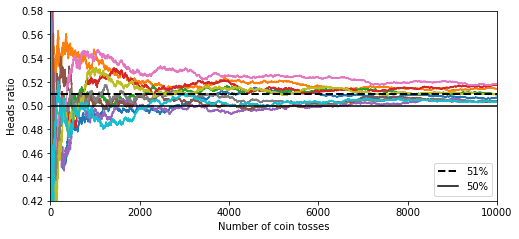

In [84]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.show()

# 큰 수의 법칙 : 더 많이 던질수록 앞면이 다수가 될 확률이 증가한다

각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것 (직접 투표)

- 앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘한다.

- 각기 다른 알고리즘으로 학습시킨다 --> 매우 다른 종류의 오차를 만들기 때문에 앙상블 모델의 정확도↑


In [2]:
# make_moons 데이터셋 불러오기
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [28]:
# 투표 기반 분류기 (VotingClassifier) 생성 후 훈련

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()      # 로지스틱 회귀
rnd_clf = RandomForestClassifier()  # 랜덤포레스트 분류기
svm_clf = SVC()
#svm_clf = SVC(probability=True)    # 클래스 확률 제공 (간접 투표 가능)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')  # voting='hard': 단순하게 가장 많은 투표를 받은 클래스를 voting 하는 방법
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                             

In [29]:
# 각 분류기의 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))   # 모델 이름, 정확도 출력

# 다른 개별 분류기보다 투표 기반 분류기가 성능이 조금 더 높다

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.912


- 직접 투표 (hard voting) : 단순하게 가장 많이 선택된 클래스를 예측

- 간접 투표 (soft voting) : 각 클래스에 대한 확률을 평균내어 가장 높은 클래스를 예측, 확률이 높은 투표에 비중을 더 둔다.

 (단, predict_proba() 메서드가 있어야 함)

 SVC에서는 클래스 확률을 제공하지 않으므로, probability=True로 지정해주어야 한다.

### 7.2 배깅과 페이스팅

배깅과 페이스팅

- **배깅 (bagging $or$ bootstrap aggregating)** : 훈련세트에서 중복을 허용하여 샘플링하는 방식

- **페이스팅 (pasting)** : 중복을 허용하지 않고 샘플링하는 방식

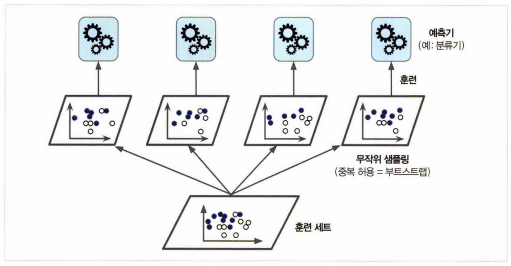

- 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아 새로운 샘플에 대한 예측을 만든다.

- 일반적으로 앙상블의 결과는 개별 예측기와 비교하면 분산이 줄어든다.

위 그림처럼 예측기는 모두 동시에 다른 CPU 코어나 서버에서 병렬로 학습시킬 수 있다. (예측도 마찬가지)

In [103]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,  # n_estimators: 앙상블 시킬 모델 수
    max_samples=100, bootstrap=True, n_jobs=-1)  # max_samples: 선택할 샘플 수,  bootstrap: 중복 허용할지, 안할지
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [105]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(tree_clf.__class__.__name__, accuracy_score(y_test, y_pred_tree)) # 개별 결정트리 모델
print(bag_clf.__class__.__name__, accuracy_score(y_test, y_pred))       # 배깅 앙상블 모델

DecisionTreeClassifier 0.856
BaggingClassifier 0.92


In [106]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

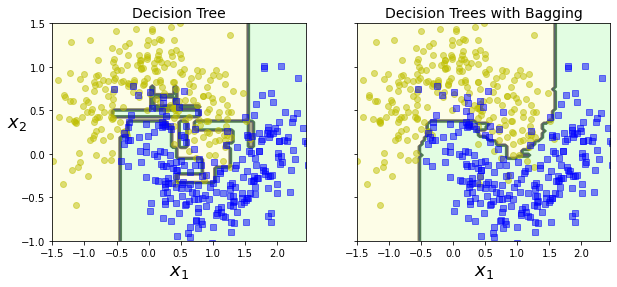

In [109]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)  # 단일 결정트리 모델의 결정경계
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)   # 배깅 앙상블 모델의 결정경계
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
plt.show()

- **oob** (out-of-bag) : 개별 모델을 훈련할 때, 선택되지 않은 훈련 샘플들

 oob 평가 : oob 샘플을 검증세트로 재활용한다.

In [147]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_   # 앙상블 모델의 평가 점수 (각 예측기의 oob평가를 평균하여 얻는다)

0.896

In [148]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)  # 테스트세트에서의 실제 정확도

0.92

In [144]:
bag_clf.oob_decision_function_[:10] # oob 샘플에 대한 각 훈련 샘플의 클래스 확률 반환

array([[0.44186047, 0.55813953],
       [0.41836735, 0.58163265],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.12637363, 0.87362637],
       [0.35051546, 0.64948454],
       [0.01829268, 0.98170732],
       [1.        , 0.        ],
       [0.98924731, 0.01075269]])

### 7.3 랜덤 패치와 랜덤 서브스페이스

BaggingClassifier는 특성 샘플링도 지원한다. (max_features, bootstrap_features로 조절)

- 랜덤 패치 방식 : 훈련 특성과 샘플을 모두 샘플링하는 것

- 랜덤 서브스페이스 방식 : 훈련 샘플을 모두 사용하고, 특성은 샘플링하는 것

 bootstrap=True, max_samples=1.0으로 설정, 

 bootstrap_features=True, 그리고/또는 max_features를 1.0보다 작게 설정

### 7.4 랜덤 포레스트

- **랜덤 포레스트** : 일반적으로 배깅 (또는 페이스팅) 방법을 적용한 결정 트리의 앙상블

 전형적으로 max_samples을 훈련 세트의 크기로 지정

In [150]:
# 최대 16개의 리프노드를 갖는 500개의 결정 트리로 이루어진 랜덤 포레스트 분류기 생성 후 훈련
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

**RandomForestClassifier**는 DecisionTreeClassifier의 매개변수와 BaggingClassifier의 매개변수를 거의 다 가지고 있다.

전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입한다.

In [153]:
# BaggingClassifier를 사용하여 앞의 RandomForestClassifier를 유사하게 만들어보자

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)

y_pred_bf = bag_clf.predict(X_test)

In [161]:
np.sum(y_pred_rf == y_pred_bf) / len(X_test)  # 예측이 거의 동일하다

0.976

- 엑스트라 트리 : 극단적으로 무작위한 트리의 랜덤 포레스트

 (보통의 결정트리처럼) 최적의 임곗값을 찾는 대신, 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택하는 방식

In [163]:
# 엑스트라 트리 모델
from sklearn.ensemble import ExtraTreesClassifier

ext_clf = ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
ext_clf.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=16, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [164]:
y_pred_ext = ext_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_ext))

0.92


랜덤 포레스트는 특성의 상대적 중요도를 측정하기 쉽다.

- 특성 중요도 :

 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성 중요도를 측정한다.

 중요도의 전체 합이 1이 되도록 정규화하여 feature_importances_ 변수에 저장된다.

랜덤 포레스트는 특히 특성을 선택해야 할 때 어떤 특성이 중요한지 빠르게 확인할 수 있다.

In [173]:
# 특성 중요도
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(f"{name:<18} {score}")

sepal length (cm)  0.11249225099876375
sepal width (cm)   0.02311928828251033
petal length (cm)  0.4410304643639577
petal width (cm)   0.4233579963547682


In [174]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

In [175]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [176]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [177]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

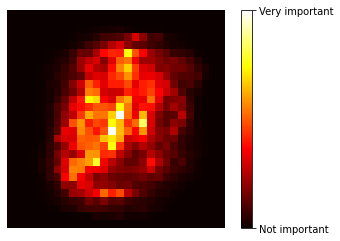

In [180]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

MNIST 데이터셋에 랜덤 포레스트 분류기를 훈련시켜 각 픽셀의 중요도를 그래프로 나타낸 이미지

### 7.5 부스팅

**부스팅** : 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법

--> 앞의 모델을 보완해나가면서 일련의 에측기를 학습시킨다.

- 에이다부스트 : 

 1. 이전 모델이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 더 높인다.

 2. 업데이트된 가중치를 사용해 다음 모델이 훈련하여 다시 예측을 만든다.

 3. 다시 가중치 업데이트 후 반복한다.

 이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다.

In [189]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

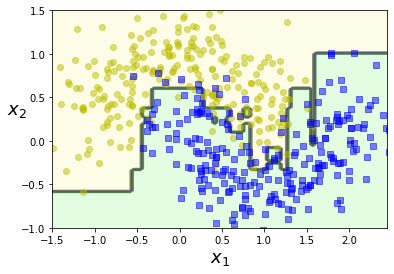

In [190]:
plot_decision_boundary(ada_clf, X, y)

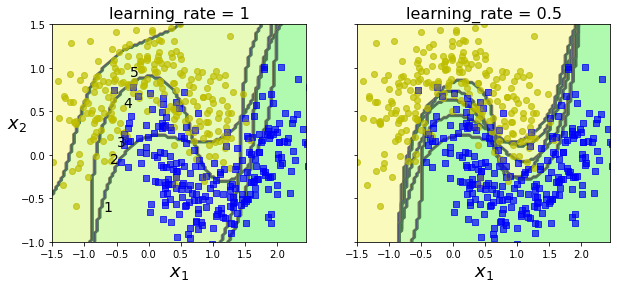

In [191]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()